In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import common
from common import multiprocess
from gym.wrappers import Monitor
import math
import copy
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random as rnd
import gym
from gym import wrappers
from gym import envs
import datetime
import time
%matplotlib inline
import os

In [2]:
!pip install Box2D

     |████████████████████████████████| 1.3 MB 2.8 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

In [4]:
#parallel environments are created to calculate fitness score 
num_envs = 10
env_name ='CartPole-v1'

def make_env():
    def _thunk():
        env = gym.make(env_name)
        return env

    return _thunk

env= [make_env() for i in range(num_envs)]
env= SubprocVecEnv(env)

In [5]:
class LunarLander(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(4, 128)
        # Output layer, 2 units - for 2 actions
        self.output = nn.Linear(128, 2)
        
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x)
        
        return x

In [6]:
def population(num_agents):
    
    agents = []
    for _ in range(num_agents):
        
        agent = LunarLander().to(device)
        
        for param in agent.parameters():
            param.requires_grad = False
            
        agents.append(agent)
                
    return agents

In [7]:
def fitness(agent):
    """
    calculates fitness score of each individual in the population. Mean of scores from 10 parallel environment
    are returned
    """
    
    agent.eval()
    
    masks=[]
    rewards=[]
    state = env.reset()
    r=0
    m=0
    for _ in range(250):
      state = torch.FloatTensor(state).to(device)
      output_probabilities = agent(state)
      action=output_probabilities.multinomial(1).squeeze(1)
      next_state, reward, done, _ = env.step(action.cpu().numpy())
      r=reward+r
      masks.append(1 - done)
      rewards.append(reward)
      state=next_state
    masks=np.array(masks)
    
    #For each environment reward is calulated till done =False. Rewards after done=True are ignored.
    idx=[np.where(masks[:,i]==0)[0][0] if(len(np.where(masks[:,i]==0)[0])>0) else len(masks) for i in range(masks.shape[1])]
    rewards=np.array(rewards)
    
    #mean of the parrallel environments
    r=np.mean([rewards[0:r,c].sum(axis=0) for c,r in enumerate(idx)])
    return r

In [8]:
def mutate(agent,eps_threshold):
    """
    input: individual to be mutated and threshold by which each weight will be mutated
    returns mutated individual
    """

    child_agent = copy.deepcopy(agent)
    
    mutation_power = eps_threshold 
            
    for param in child_agent.parameters():
                                        
        if(len(param.shape)==2): #weights of linear layer
            for i0 in range(param.shape[0]):
                for i1 in range(param.shape[1]):
                    if rnd.random()<0.6:
                      param[i0][i1]+= mutation_power * np.random.randn()
                        

        elif(len(param.shape)==1): #biases of linear layer or conv layer
            for i0 in range(param.shape[0]):
                if rnd.random()<0.6:
                  param[i0]+=mutation_power * np.random.randn()

    return child_agent

In [9]:
def uniform_crossover(ind1,ind2,layers,uni_prob,mut_threshold):
    """
    input: ind1,ind2 - parents between whom crossover is to be performed
           layers - total layers in the neural net * 2(to account for the bias)
           uni_prob - probability for uniform crossover
           mut_threshold - probability for mutation
    returns tweaked copy of parents
    """
    offspring=[]
    for i in range(layers):
        dim=list(ind1.parameters())[i].shape
        idx=torch.randperm(int(np.prod(dim)*uni_prob)).reshape(1,-1).to(device)
        list(ind1.parameters())[i]=list(ind1.parameters())[i].reshape(1,-1).scatter_(1,idx,list(ind2.parameters())[i].reshape(1,-1)).reshape(dim)
        list(ind2.parameters())[i]=list(ind2.parameters())[i].reshape(1,-1).scatter_(1,idx,list(ind1.parameters())[i].reshape(1,-1)).reshape(dim)
    sample = rnd.random()
    if sample<0.4:
        ind1=mutate(ind1,mut_threshold)
        ind2=mutate(ind2,mut_threshold)
    offspring.extend((ind1,ind2))
    return offspring

In [10]:
def return_mutation(agents, sorted_parent_indexes,n_elite,n_mut,mut_threshold):
    
    children_agents = []
    
    for i in range(n_mut-n_elite):
        
        selected_agent_index = sorted_parent_indexes[np.random.randint(len(sorted_parent_indexes))]
        children_agents.append(mutate(agents[selected_agent_index],mut_threshold))
        
    for i in range(n_elite):
        children_agents.append(agents[sorted_parent_indexes[i]])
    return children_agents

In [11]:
def rank_selection(agents, sorted_parent_indexes,cross):
    """Select individuals for reproduction by giving preference to fittest individuals
    """
    
    children_agents = []

    for i in range(cross):
        
        selected_agent_index = sorted_parent_indexes[np.random.randint(len(sorted_parent_indexes))]
#         print("selected_agent_index",selected_agent_index)
        children_agents.append(agents[selected_agent_index])
    return children_agents

In [12]:
game_actions = 2 #2 actions possible: left or right

#disable gradients as we will not use them
torch.set_grad_enabled(False)

# initialize N number of agents
num_agents = 150
n_elite=5

agents = population(num_agents)
# # How many top agents to consider as parents
top_limit = 20

# # # run evolution until X generations
generations = 500

#threshold decay for crossover
EPS_START = 0.6
EPS_END = 0.2

steps_done=0

#mutation threshold is exponentially decayed from 0.9 (higher exploration) to 0.01 in later generations
MUT_START = 0.90
MUT_END = 0.01
EPS_DECAY = 200
cross=round(num_agents*0.7/2)*2
mut=num_agents-cross
scores=[]

for generation in range(generations):

    # return rewards of agents
    rewards=list(map(fitness,agents))
    
    #select top 20 individuals
    sorted_parent_indexes = np.argsort(rewards)[::-1][:top_limit]
    
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
    math.exp(-1. * steps_done / EPS_DECAY)
    
    
    mut_threshold = EPS_END + (MUT_START - MUT_END) * \
    math.exp(-1. * steps_done / EPS_DECAY)

    #select children for breeding
    mating=rank_selection(agents, sorted_parent_indexes,cross)
    children=[]
    for j in range(int(len(mating)/2)):
        
        #perform crossover of 70% population
        child=uniform_crossover(mating[j],mating[len(mating)-j-1],4,0.2,eps_threshold)  
        children.extend(child)

    #only mutate 30% of the population
    children_agents=return_mutation(agents, sorted_parent_indexes,n_elite,mut,mut_threshold) 
    children=children_agents+children
  
    print("")
    print("")
    
    top_rewards = []
    for best_parent in sorted_parent_indexes:
        top_rewards.append(rewards[best_parent])
    

    agents=children 
    print("Generation ", generation, " | Mean rewards: ", np.mean(rewards), " | Mean of top 5: ",np.mean(top_rewards[:5]))

    print("Rewards for top: ",top_rewards)
    scores.append(top_rewards[0])
    if len(scores) >= 100:
        if np.mean(scores[-100:]) >= 195.0:
            print('Solved after' + str(generation-100) + ' episodes')
            break

    steps_done+=1
#     env.render()



Generation  0  | Mean rewards:  19.055333333333333  | Mean of top 5:  28.4
Rewards for top:  [31.3, 28.2, 28.0, 27.6, 26.9, 26.6, 26.2, 25.8, 25.5, 25.4, 25.1, 24.9, 24.3, 24.0, 23.9, 23.8, 23.7, 23.5, 23.1, 22.9]


Generation  1  | Mean rewards:  15.68733333333333  | Mean of top 5:  47.14000000000001
Rewards for top:  [68.2, 47.2, 43.7, 40.9, 35.7, 32.6, 32.5, 29.1, 28.5, 27.6, 27.2, 26.2, 25.5, 25.5, 25.3, 25.0, 24.8, 24.2, 24.2, 24.1]


Generation  2  | Mean rewards:  16.621333333333332  | Mean of top 5:  50.8
Rewards for top:  [64.5, 48.8, 48.3, 47.2, 45.2, 45.0, 45.0, 43.6, 43.1, 42.5, 41.6, 41.3, 41.1, 37.8, 37.1, 35.9, 34.0, 32.0, 31.1, 30.1]


Generation  3  | Mean rewards:  17.69533333333333  | Mean of top 5:  62.15999999999999
Rewards for top:  [80.5, 71.0, 58.9, 51.0, 49.4, 48.8, 48.3, 47.6, 46.0, 45.7, 44.4, 37.5, 35.5, 35.5, 35.3, 32.3, 31.7, 30.7, 30.5, 30.3]


Generation  4  | Mean rewards:  31.533999999999995  | Mean of top 5:  102.8
Rewards for top:  [116.1, 111.9, 1



Generation  36  | Mean rewards:  136.08466666666666  | Mean of top 5:  250.0
Rewards for top:  [250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 249.8, 249.2]


Generation  37  | Mean rewards:  116.76933333333335  | Mean of top 5:  250.0
Rewards for top:  [250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 242.8, 241.6, 241.5, 237.7, 235.6, 231.4]


Generation  38  | Mean rewards:  93.13600000000001  | Mean of top 5:  250.0
Rewards for top:  [250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0]


Generation  39  | Mean rewards:  105.92333333333333  | Mean of top 5:  250.0
Rewards for top:  [250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 248.2, 247.7, 247.0, 246.3, 244.6, 242.8, 242.7, 242.7, 242.0]


Generation  40  | Mean rewards:  92.182  | Mean



Generation  71  | Mean rewards:  222.25133333333332  | Mean of top 5:  250.0
Rewards for top:  [250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0]


Generation  72  | Mean rewards:  226.088  | Mean of top 5:  250.0
Rewards for top:  [250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0]


Generation  73  | Mean rewards:  220.99  | Mean of top 5:  250.0
Rewards for top:  [250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0]


Generation  74  | Mean rewards:  215.15133333333333  | Mean of top 5:  250.0
Rewards for top:  [250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0, 250.0]


Generation  75  | Mean rewards:  228.37466666666668  | Mean of top 5:

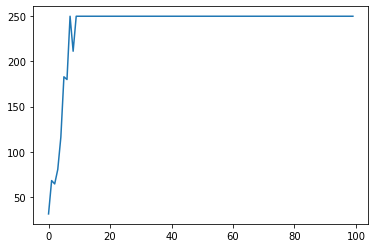

In [19]:
#plot rewards for the top agent during training for each episode
plt.plot(range(len(scores)),scores)

In [14]:
#select one of the top performing agent
rewards=list(map(fitness,agents))
sorted_parent_indexes = np.argsort(rewards)[::-1][:top_limit]
top_agent=agents[sorted_parent_indexes[0]]

In [15]:
#creating single environment for testing
env_1= gym.make(env_name)

#Play a random game
def plot_reward(n,agent):
    for i in range(n):
        state = env_1.reset()
        r=0
        done = False
        while not done:
          state = torch.FloatTensor(state).unsqueeze(0).to(device)
          output_probabilities = agent(state)#.cpu().numpy()[0]
          action=output_probabilities.multinomial(1).squeeze(1).cpu().numpy()[0]
          state, reward, done, _ = env_1.step(action)
          r=r+reward
        print(f"episode {i} reward {r}")

In [16]:
#reward for top agent after training
plot_reward(10,top_agent)

episode 0 reward 316.0
episode 1 reward 285.0
episode 2 reward 319.0
episode 3 reward 289.0
episode 4 reward 343.0
episode 5 reward 343.0
episode 6 reward 306.0
episode 7 reward 347.0
episode 8 reward 315.0
episode 9 reward 325.0
